In [13]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
from pathlib import Path

# --- Step 2: Define data loaders ---
def load_data(input_file):
    """
    Load waveform data from CSV.
    Expects waveform columns to start with 't'.
    """
    df = pd.read_csv(input_file)
    waveforms = df[[c for c in df.columns if c.startswith("t")]].values
    return df, waveforms

def load_config(config_path):
    """
    Load YAML configuration file.
    """
    with open(config_path, "r") as f:
        return yaml.safe_load(f)


Loaded 9065 waveforms with shape (9065, 400)
Loaded 9065 waveforms from data/run0006/layer1_x3_y1.csv
Position: layer=1, x=3, y=1


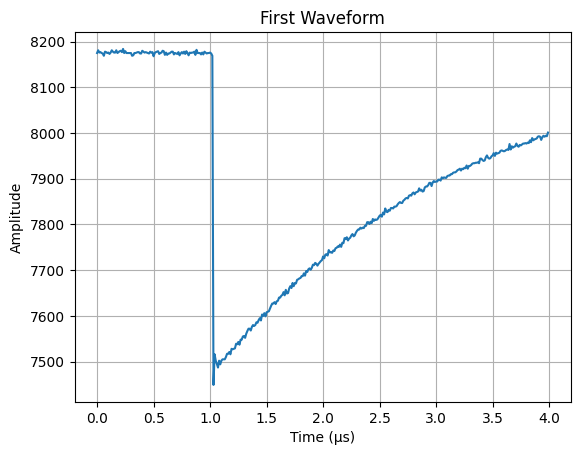

In [26]:
# Define the base directory
BASE_DIR = Path("../").resolve()  # from base/notebooks to base/

# Define path to config file (relative to notebook, still works)
config_path = BASE_DIR / "config" / "play_layer1_x3_y1.yaml"

cfg = load_config(config_path)

# Load waveform data
input_file = BASE_DIR / cfg["input_file"]
df, waveforms = load_data(input_file)
print(f"Loaded {len(waveforms)} waveforms with shape {waveforms.shape}")

print(f"Loaded {len(waveforms)} waveforms from {cfg['input_file']}")
print(f"Position: layer={cfg['layer']}, x={cfg['x']}, y={cfg['y']}")

# --- Extract parameters ---
params = cfg["initial_params"].copy()
sampling = params["sampling"]  # in ns
dt = sampling * 1e-9           # in seconds

# Create a time axis based on waveform length
n_samples = waveforms.shape[1]
time_axis = np.arange(n_samples) * dt

# Optional preview of first waveform
plt.plot(time_axis * 1e6, waveforms[0])  # Convert time to µs
plt.title("First Waveform")
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [27]:
def MWD(trace, params, baseline_corr=True):
    """
    Python translation of MWD algorithm from C4 LisaRaw2Ana.cxx
    Returns MWD trace, energy, and flatness.
    """

    sampling = params["sampling"]
    smoothing_L = params["smoothing_L"]
    MWD_length = params["MWD_length"]
    decay_time = params["decay_time"]

    # Index conversions
    LL = int(smoothing_L / sampling)
    MM = int(MWD_length / sampling)
    tau = decay_time / sampling

    k0 = int(params["MWD_trace_start"] / sampling)
    kend = int(params["MWD_trace_stop"] / sampling)

    amp_start_idx = int(params["MWD_amp_start"] / sampling) - k0
    amp_stop_idx = int(params["MWD_amp_stop"] / sampling) - k0

    baseline_start_idx = int(params["MWD_baseline_start"] / sampling) - k0
    baseline_stop_idx = int(params["MWD_baseline_stop"] / sampling) - k0
    
    # Baseline correction
    baseline = np.mean(trace[20:150]) if baseline_corr else 0.0
    trace_febex_0 = (np.array(trace) - baseline) / 8.0
        
    # MWD trace calculation
    trace_mwd = []
    for kk in range(k0, min(kend, len(trace))):
        DM = 0.0
        sum0 = None
        for j in range(kk - LL, kk):
            if j < 1 or (j - MM) < 0 or j >= len(trace_febex_0):
                continue
            if sum0 is None:
                sum0 = np.sum(trace_febex_0[max(0, j - MM):j])
            else:
                if (j - MM - 1) >= 0:
                    sum0 -= trace_febex_0[j - MM - 1]
                sum0 += trace_febex_0[j - 1]
            DM += trace_febex_0[j] - trace_febex_0[j - MM] + sum0 / tau
        trace_mwd.append(DM / LL)

    trace_mwd = np.array(trace_mwd)

    # Energy and flatness calculation
    valid = (
        0 <= amp_start_idx < amp_stop_idx <= len(trace_mwd)
        and 0 <= baseline_start_idx < baseline_stop_idx <= len(trace_mwd)
    )

    if valid:
        energy_flat = np.mean(trace_mwd[amp_start_idx:amp_stop_idx])
        energy_base = np.mean(trace_mwd[baseline_start_idx:baseline_stop_idx])
        energy = abs(energy_flat - energy_base)
        flat_top = trace_mwd[amp_start_idx:amp_stop_idx]
        flatness = np.std(flat_top) / np.mean(flat_top)
    else:
        energy = np.nan
        flatness = np.nan

    return trace_mwd, energy, flatness


In [28]:
from scipy.ndimage import gaussian_filter1d

def extract_metrics(waveform, params, time_axis=None):
    """
    Extract multiple energy-related features from a waveform.
    Returns a dict of metrics.
    """
    metrics = {}

    # --- MWD energy ---
    _, energy_mwd, _ = MWD(waveform, params)
    metrics["MWD_energy"] = energy_mwd

    # --- Max amplitude ---
    metrics["max_amplitude"] = np.abs(waveform).max()

    # --- Fixed-window integration ---
    start = params.get("MWD_amp_start", 1350.0)
    stop = params.get("MWD_amp_stop", 1400.0)
    
    # Convert to indices based on sampling
    dt = params["sampling"]  # in ns
    i_start = int(start / dt)
    i_stop = int(stop / dt)
    metrics["fixed_window_integral"] = np.trapz(waveform[i_start:i_stop])

    # --- Smoothed peak ---
    sigma = params.get("smoothing_sigma", 5)
    smoothed = gaussian_filter1d(waveform, sigma=sigma)
    metrics["smoothed_peak"] = smoothed.max()

    return metrics


In [29]:
from tqdm.notebook import tqdm

# --- Extract metrics for all waveforms with progress bar ---
all_metrics = [extract_metrics(wf, params) for wf in tqdm(waveforms, desc="Extracting metrics")]
df_metrics = pd.DataFrame(all_metrics)
df_metrics.head()

Extracting metrics:   0%|          | 0/9065 [00:00<?, ?it/s]

,MWD_energy,max_amplitude,fixed_window_integral,smoothed_peak
0,86.603191,8184,30299.0,8177
1,80.068462,8186,30486.5,8177
2,86.909234,8182,30279.0,8177
3,84.107780,8182,30376.0,8177
4,85.272594,8183,30354.0,8176


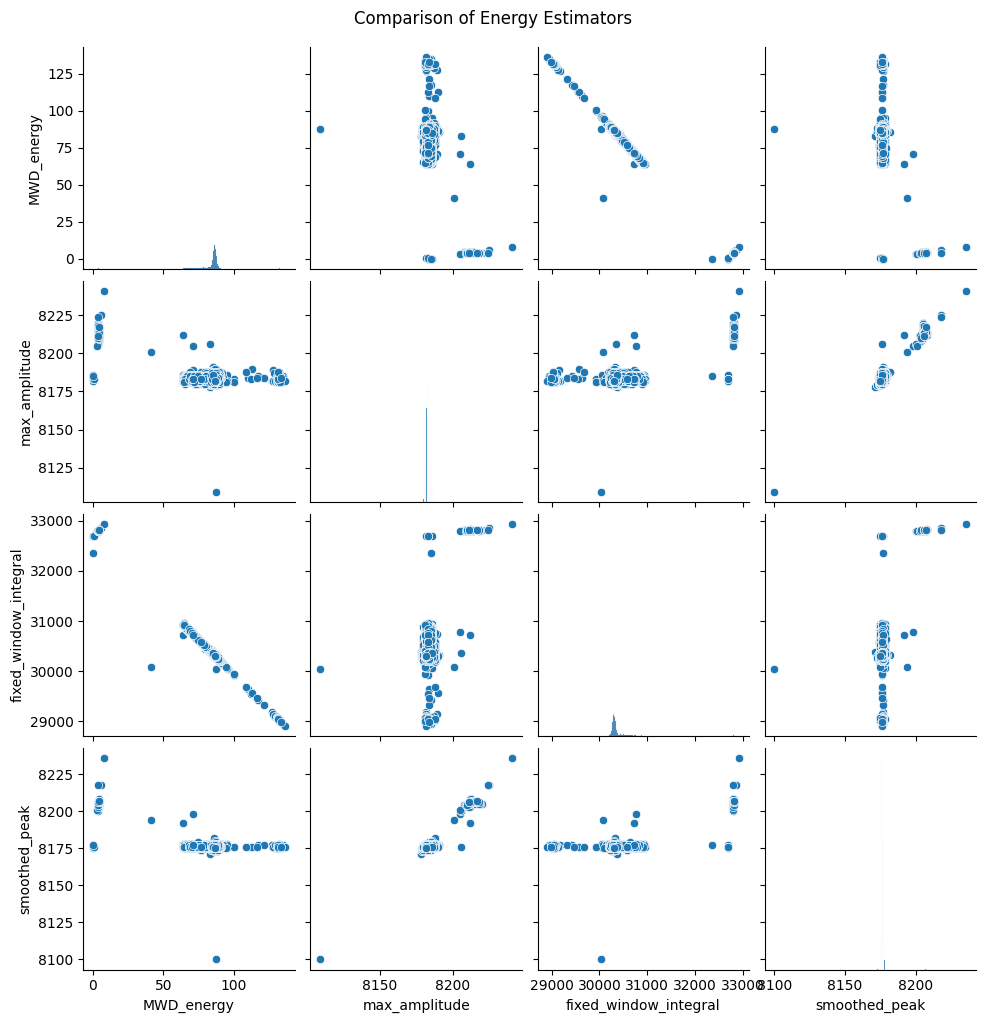

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_metrics)
plt.suptitle("Comparison of Energy Estimators", y=1.02)
plt.show()

In [31]:
from scipy.optimize import curve_fit
def gaussian(x, A, mean, sigma):
    return A * np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_energy_spectrum(energies, bins=200, expand_window=False):
    counts, edges = np.histogram(energies, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2

    rms = np.std(energies)
    peak = centers[np.argmax(counts)]
    window = 2 * rms if expand_window else 1 * rms
    mask = (centers > peak - window) & (centers < peak + window)
    x_fit = centers[mask]
    y_fit = counts[mask]
    
    try:
        A0 = max(y_fit)
        sigma0 = rms
        popt, _ = curve_fit(
            gaussian,
            x_fit,
            y_fit,
            p0=[A0, peak, sigma0],
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf])  # force sigma > 0
        )
        A, mean, sigma = popt
        resolution = sigma / mean * 100
        return centers, counts, mean, sigma, resolution
    except Exception as e:
        print(f"Fit failed: {e}")
        return centers, counts, None, None, None


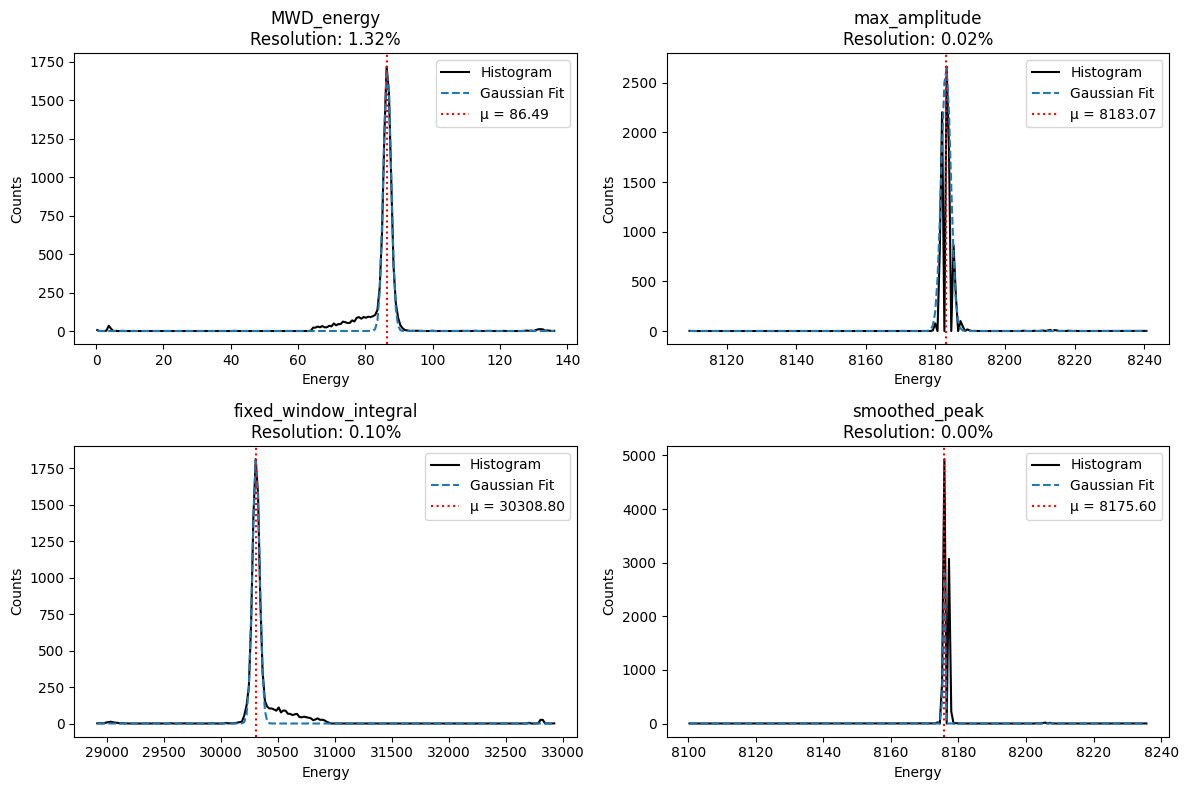

In [32]:
methods = ["MWD_energy", "max_amplitude", "fixed_window_integral", "smoothed_peak"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, method in enumerate(methods):
    ax = axes[i]
    energies = df_metrics[method].dropna()
    
    centers, counts, mean, sigma, res = fit_energy_spectrum(energies)
    
    ax.plot(centers, counts, label="Histogram", color="black")
    
    if mean is not None:
        ax.plot(centers, gaussian(centers, max(counts), mean, sigma), label="Gaussian Fit", linestyle='--')
        ax.axvline(mean, color='red', linestyle=':', label=f"μ = {mean:.2f}")
        ax.set_title(f"{method}\nResolution: {res:.2f}%")
    else:
        ax.set_title(f"{method}\nFit failed")
    
    ax.set_xlabel("Energy")
    ax.set_ylabel("Counts")
    ax.legend()

plt.tight_layout()
plt.show()

In [63]:
import numpy as np
# Sampling info
sampling_ns = 10
dt = sampling_ns * 1e-3  # 10 ns → 0.01 µs
t = np.arange(len(wf)) * dt

# Trapezoidal filter function (correct vectorized)
def trapezoidal_filter(waveform, L=20, G=10):
    N = len(waveform)
    if 2 * L + G >= N:
        raise ValueError("Waveform too short for selected L and G.")

    y = np.zeros(N)
    wf = waveform.astype(np.float64)
    cumsum = np.cumsum(np.insert(wf, 0, 0))

    sum_a = cumsum[L:] - cumsum[:-L]
    sum_b = cumsum[L + G:] - cumsum[:-L - G]
    n_valid = N - (2 * L + G)
    trapezoid = sum_a[G + L:G + L + n_valid] - sum_b[L:L + n_valid]
    y[2 * L + G:] = trapezoid

    return y

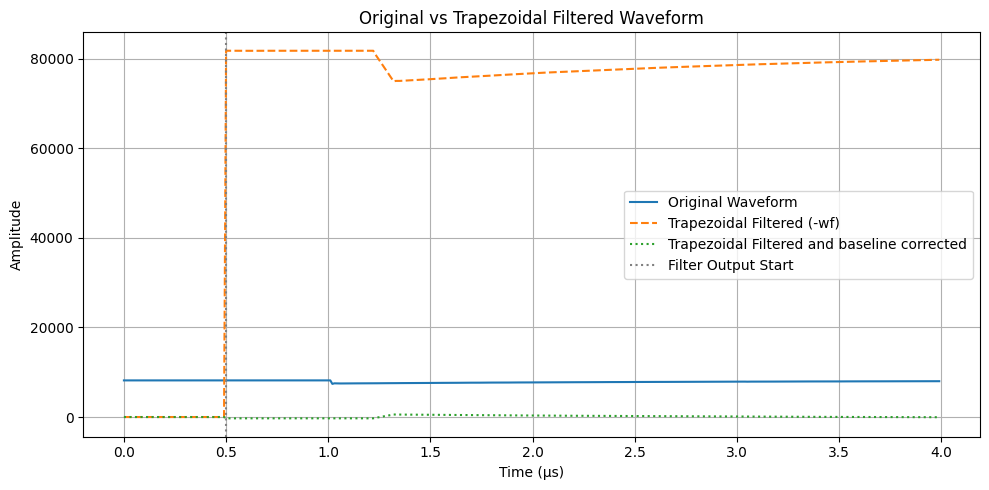

In [78]:

# Apply the trapezoidal filter to inverted waveform
L = 20
G = 10
baseline = np.mean(wf[20:150])
wf_corr = (np.array(wf) - baseline) / 8.0
filtered = trapezoidal_filter(-wf, L, G)
filtered_corr = trapezoidal_filter(wf_corr, L, G)
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t, wf, label="Original Waveform")
plt.plot(t, filtered, '--', label="Trapezoidal Filtered (-wf)")
plt.plot(t, filtered_corr, ':', label="Trapezoidal Filtered and baseline corrected")
plt.axvline(t[2 * L + G], color='gray', linestyle=':', label='Filter Output Start')
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")
plt.title("Original vs Trapezoidal Filtered Waveform")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [85]:
energies_trap = []

for wf in tqdm(waveforms, desc="Trapezoidal energy"):
    baseline = np.mean(wf[20:150])
    wf_corr = (np.array(wf) - baseline) / 8.0
    filtered = trapezoidal_filter(-wf_corr, L, G)

    start = 2 * L + G
    flat = filtered[start:start + 10]
    flat_top_energy = np.mean(flat)

    baseline_est = np.mean(filtered[start - 50:start - 40])
    trap_energy = abs(flat_top_energy - baseline_est)

    energies_trap.append(trap_energy)

df_metrics["trap_energy"] = energies_trap

Trapezoidal energy:   0%|          | 0/9065 [00:00<?, ?it/s]

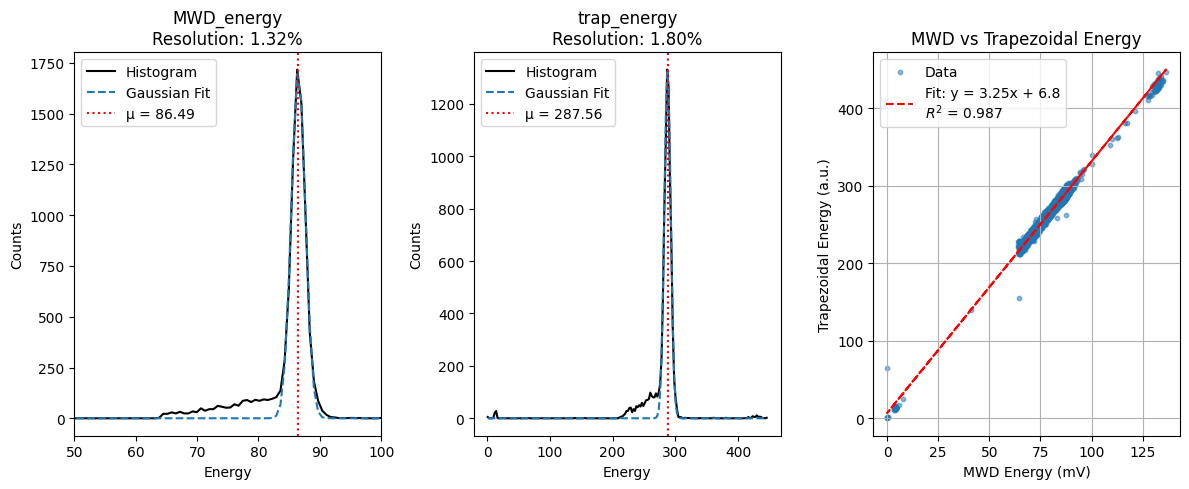

In [86]:
methods = ["MWD_energy", "trap_energy"]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes = axes.flatten()

for i, method in enumerate(methods):
    ax = axes[i]
    energies = df_metrics[method].dropna()
    
    centers, counts, mean, sigma, res = fit_energy_spectrum(energies)
    
    ax.plot(centers, counts, label="Histogram", color="black")
    
    if mean is not None:
        ax.plot(centers, gaussian(centers, max(counts), mean, sigma), label="Gaussian Fit", linestyle='--')
        ax.axvline(mean, color='red', linestyle=':', label=f"μ = {mean:.2f}")
        ax.set_title(f"{method}\nResolution: {res:.2f}%")
    else:
        ax.set_title(f"{method}\nFit failed")
    
    ax.set_xlabel("Energy")
    ax.set_ylabel("Counts")
    ax.legend()

axes[0].set_xlim(50,100)
#axes[1].set_xlim(81600,81900)
from scipy.stats import linregress

x = df_metrics["MWD_energy"]
y = df_metrics["trap_energy"]
slope, intercept, r, *_ = linregress(x, y)

axes[-1].scatter(x, y, alpha=0.5, s=10, label='Data')
#axes[-1].set_ylim(81600,81900)
axes[-1].plot(x, slope * x + intercept, 'r--', label=f'Fit: y = {slope:.2f}x + {intercept:.1f}\n$R^2$ = {r**2:.3f}')
axes[-1].set_xlabel("MWD Energy (mV)")
axes[-1].set_ylabel("Trapezoidal Energy (a.u.)")
axes[-1].set_title("MWD vs Trapezoidal Energy")
axes[-1].grid(True)
axes[-1].legend()

plt.tight_layout()
plt.show()

In [88]:
def Trap(waveforms, L, G): 
    energies_trap = []
    for wf in tqdm(waveforms, desc="Trapezoidal energy"):
        baseline = np.mean(wf[20:150])
        wf_corr = (np.array(wf) - baseline) / 8.0
        filtered = trapezoidal_filter(-wf_corr, L, G)

        start = 2 * L + G
        flat = filtered[start:start + 10]
        flat_top_energy = np.mean(flat)

        baseline_est = np.mean(filtered[start - 50:start - 40])
        trap_energy = abs(flat_top_energy - baseline_est)

        energies_trap.append(trap_energy)

    return energies_trap

In [93]:

from time import perf_counter
from tqdm import tqdm  # optional for progress bar

# Trapezoidal timing
start = perf_counter()
for wf in waveforms:
    baseline = np.mean(wf[20:150])
    wf_corr = (np.array(wf) - baseline) / 8.0
    filtered = trapezoidal_filter(-wf_corr, L=20, G=10)
    energy = np.mean(filtered[2 * 20 + 10:2 * 20 + 10 + 10])
end = perf_counter()
print(f"Trapezoidal total time: {end - start:.2f} sec")

# MWD timing
startM = perf_counter()
for wf in waveforms:
    _, energy_mwd, _ = MWD(wf, params)
endM = perf_counter()
print(f"MWD total time: {endM - startM:.2f} sec")

Trapezoidal total time: 0.71 sec
MWD total time: 27.12 sec


In [94]:
n_waveforms = len(waveforms)
print(f"Trapezoidal per waveform: {(end - start) / n_waveforms * 1e3:.2f} ms")
print(f"MWD per waveform: {(endM - startM) / n_waveforms * 1e3:.2f} ms")


Trapezoidal per waveform: 0.08 ms
MWD per waveform: 2.99 ms


In [111]:
L_values = [i for i in range(1,30,2)]
G_values = [i for i in range(1,40,2)]
print(L_values)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


In [112]:
from tqdm import tqdm
import pandas as pd

results = []

for L in tqdm(L_values, desc="L loop"):
    for G in G_values:
        if 2 * L + G >= waveforms.shape[1]:
            continue  # skip if filter won't fit in waveform

        energies = []
        for wf in waveforms:
            baseline = np.mean(wf[20:150])
            wf_corr = (np.array(wf) - baseline) / 8.0
            filtered = trapezoidal_filter(-wf_corr, L, G)

            start = 2 * L + G
            flat = filtered[start:start + 10]
            flat_top = np.mean(flat)
            baseline_est = np.mean(filtered[start - 50:start - 40])
            energy = abs(flat_top - baseline_est)
            energies.append(energy)

        energies = np.array(energies)
        energies = energies[np.isfinite(energies)]
        if len(energies) == 0:
            continue
        centers, counts, mean, sigma, resolution = fit_energy_spectrum(energies)
        results.append({"L": L, "G": G, "resolution": resolution})

# Convert to DataFrame
df_opt = pd.DataFrame(results)

L loop:   0%|                                            | 0/15 [00:00<?, ?it/s]/home/wimmer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wimmer/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
L loop: 100%|███████████████████████████████████| 15/15 [02:59<00:00, 11.98s/it]


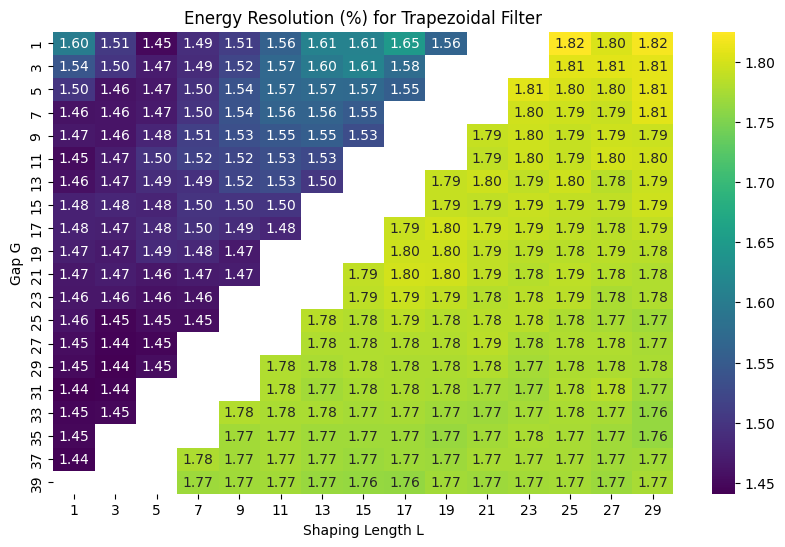

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
pivot = df_opt.pivot(index="G", columns="L", values="resolution")
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title("Energy Resolution (%) for Trapezoidal Filter")
plt.xlabel("Shaping Length L")
plt.ylabel("Gap G")
plt.show()